In [18]:
from medigraph.data.abide import AbideData
import numpy as np
from nilearn import plotting
from medigraph.model.gcn import GCN
from medigraph.model.baseline import DenseNN
import torch
from tqdm.notebook import tqdm
from medigraph.data.preprocess import sanitize_data, visual_sanity_check_input, whiten
from medigraph.train import training_loop
from medigraph.data.properties import INPUTS, LABELS
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%load_ext autoreload
%autoreload 2
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cpu')

In [19]:
dat = AbideData()

### Check connectivy matrix for a single patient
- 111x111 matrices
- We'll retrieve the $6216=\frac{111*(111+1)}{2}$ raw coefficients from the upper triangular matrix

input feature vector shape: (6216,)


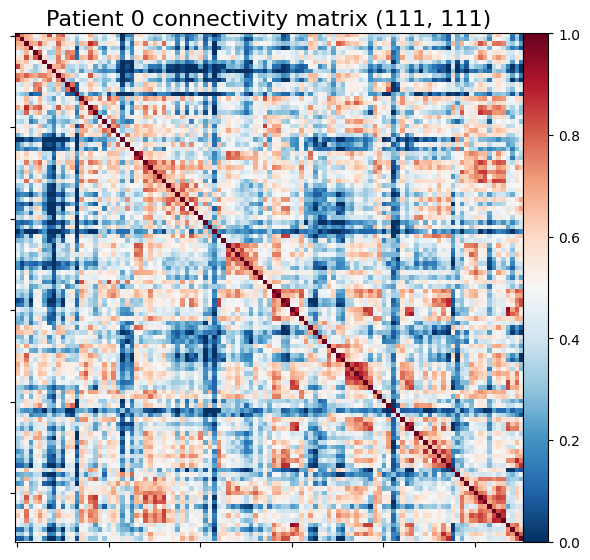

In [20]:
# Get the connectivity matrix for the first subject
idx = 0
mat = dat.get_connectivity_matrix(idx)
plotting.plot_matrix(
    mat,
    figure=(6, 6),
    vmax=1,
    vmin=0,
    title=f"Patient {idx} connectivity matrix {mat.shape}"
)
feature_vector_input = dat.get_connectivity_features(idx)
print(f"input feature vector shape: {feature_vector_input.shape}")

# Train classifier
### Build adjacency, features matrix and classification labels

In [21]:
# % Build adjacency matrix and input feature vectors
inp_np, lab_np, adj_np = dat.get_training_data()
print(f"Adjacency matrix : {adj_np.shape} [VxV]")
print(f"Labels {lab_np.shape} : [V]")
print(f"Input feature vector {inp_np.shape} : [VxF]")

Adjacency matrix : (871, 871) [VxV]
Labels (871,) : [V]
Input feature vector (871, 6216) : [VxF]


In [22]:
# % Load data to GPU
labels_np = dat.get_labels()
adj = torch.tensor(adj_np, dtype=torch.float32).to(device)
inp_raw = torch.tensor(inp_np, dtype=torch.float32).to(device)  # [V=871,  F=6216]
lab = torch.tensor(labels_np, dtype=torch.float32).to(device)  # for binary classification

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, bottleneck_dim):
        super(AutoEncoder, self).__init__()
        self.fc_encoder = nn.Sequential(
                            # nn.Linear(input_dim, hidden_dim),
                            # nn.Tanh(),
                            nn.Linear(input_dim, bottleneck_dim)
                            )
        self.fc_decoder = nn.Sequential(
                            nn.Linear(bottleneck_dim, input_dim),
                            # nn.Tanh(),
                            # nn.Linear(hidden_dim, input_dim)
                            )
                  
    def forward(self, x):
        x = self.fc_encoder(x)
        x = torch.tanh(x)
        x = self.fc_decoder(x)

        return x

In [24]:
def get_loader(train_dataset, batch_size=64, num_workers=1, mode='train'):
    """Build and return data loader."""
    if mode == 'train':
        shuffle = True
    else:
        shuffle = False

    data_loader = DataLoader(train_dataset,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             num_workers=num_workers,
                             drop_last=True)
  
    return data_loader

In [50]:
"""Training loop
"""
import torch
from tqdm.notebook import tqdm
from medigraph.data.properties import INPUTS, LABELS
from typing import Tuple, Optional


def training_loop(
    model: torch.nn.Module,
    train_data: dict,
    val_data: dict, 
    device,
    optimizer_params={
        "lr": 1.E-4,
        "weight_decay": 0.001
    },
    n_epochs: Optional[int] = 1000,
    batch_size: Optional[int] = 256
) -> Tuple[torch.nn.Module, dict]:
    criterion = torch.nn.MSELoss()
    train_input = train_data[INPUTS]
    val_input = val_data[INPUTS]
    train_loader = DataLoader(train_input, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_input, batch_size=batch_size, shuffle=False)

    model.to(device)
    optim = torch.optim.Adam(model.parameters(), **optimizer_params)
    training_losses = []
    validation_losses = []
    for ep in tqdm(range(n_epochs)):
        model.train()
        for batch_data in train_loader:
            batch_data = batch_data.to(device)
            optim.zero_grad()
            output = model(batch_data)
            loss = criterion(batch_data, output)
            loss.backward()
            optim.step()

        print(f"Epoch {ep} training loss: {loss.item():10f}")
        training_losses.append(loss.detach().cpu())
        
        model.eval()
        with torch.no_grad():
            val_loss_mean = 0
            i = 0
            for val_batch_data in val_loader:
                i += 1
                val_batch_data = val_batch_data.to(device)
                val_output = model(val_batch_data)
                val_loss = criterion(val_batch_data, val_output)
                validation_losses.append(val_loss.item())
                val_loss_mean += val_loss.item()
            val_loss_mean /= i
            if ep % 10 == 0:
                print(f"Epoch {ep} validation loss: {val_loss_mean:10f}")
        
    metrics = {
        "training_losses": training_losses,
        "validation_losses": validation_losses
        }
    return model, metrics

In [26]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

train_dataset, X_test = train_test_split(inp_raw, test_size=0.2, random_state=42) # make the random split reproducible
train_dataset = TensorDataset(train_dataset)
test_dataset = TensorDataset(X_test)
train_loader = get_loader(train_dataset)
test_loader = get_loader(test_dataset)

len(train_dataset), len(X_test)

(696, 175)

In [27]:
# % Sanitize and whiten data
clean_inp = sanitize_data(inp_raw)
inp = whiten(clean_inp)
inp.shape, adj.shape, lab.shape

(torch.Size([871, 6105]), torch.Size([871, 871]), torch.Size([871]))

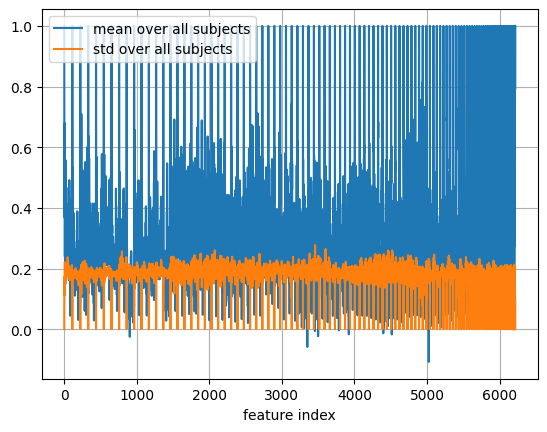

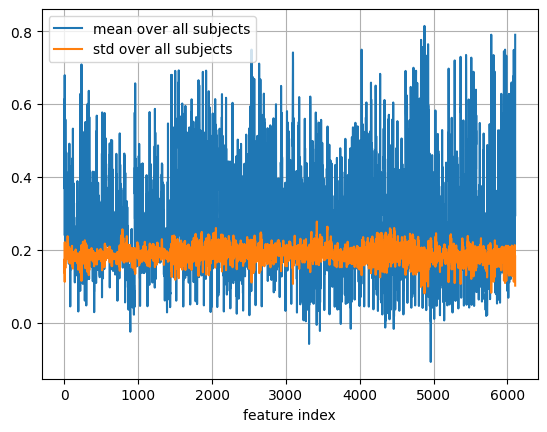

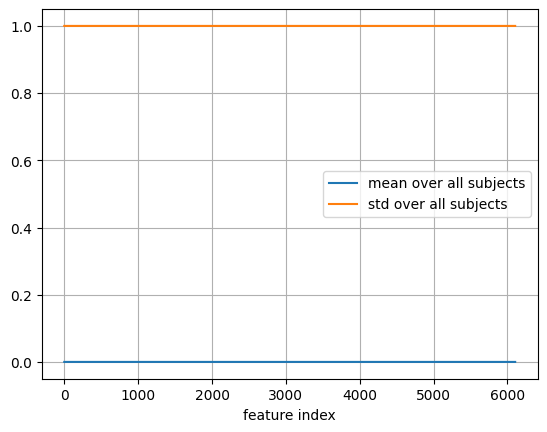

In [28]:
# % Visalization of sanity check
visual_sanity_check_input(inp_raw)
visual_sanity_check_input(clean_inp)
visual_sanity_check_input(inp)

In [51]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

inp_train, inp_test = train_test_split(inp, test_size=0.1, random_state=42) # make the random split reproducible

In [60]:
training_data = {
    INPUTS: inp,
    LABELS: lab
}

val_data = {
    INPUTS: inp_test,
    LABELS: lab
}

nb_samples = training_data[INPUTS].shape[0]
input_features = training_data[INPUTS].shape[1]
bottleneck_dim = 2000
hidden_dim = 1000
num_classes = 2
lr = 1e-2
nb_epochs = 150

AE = AutoEncoder(input_features, hidden_dim, bottleneck_dim)
AE.to(device)
AE, metrics = training_loop(AE, training_data, val_data, device, n_epochs=nb_epochs)

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 0 training loss:   0.874052
Epoch 0 validation loss:   0.825341
Epoch 1 training loss:   0.715536
Epoch 2 training loss:   0.724980
Epoch 3 training loss:   0.699880
Epoch 4 training loss:   0.632731
Epoch 5 training loss:   0.623168
Epoch 6 training loss:   0.617511
Epoch 7 training loss:   0.586090
Epoch 8 training loss:   0.540454
Epoch 9 training loss:   0.534998
Epoch 10 training loss:   0.518834
Epoch 10 validation loss:   0.515563
Epoch 11 training loss:   0.504395
Epoch 12 training loss:   0.504100
Epoch 13 training loss:   0.511718
Epoch 14 training loss:   0.476889
Epoch 15 training loss:   0.476022
Epoch 16 training loss:   0.471526
Epoch 17 training loss:   0.484329
Epoch 18 training loss:   0.457400
Epoch 19 training loss:   0.442435
Epoch 20 training loss:   0.431189
Epoch 20 validation loss:   0.422401
Epoch 21 training loss:   0.413897
Epoch 22 training loss:   0.413949
Epoch 23 training loss:   0.416754
Epoch 24 training loss:   0.419205
Epoch 25 training loss:  

In [61]:
torch.save(AE, 'simple_AE_1000.pth')

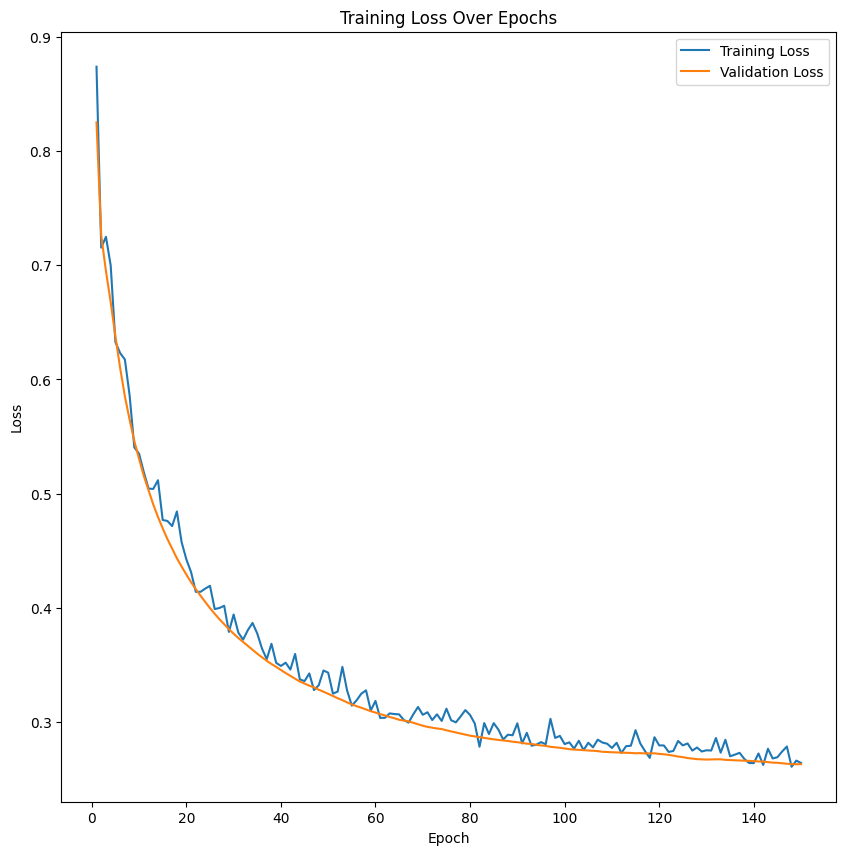

In [62]:
import matplotlib.pyplot as plt
import torch

def plot_losses(metrics):
    training_losses = metrics['training_losses']
    validation_losses = metrics['validation_losses']

    plt.figure(figsize=(10, 10))
    plt.plot(range(1, len(training_losses) + 1), [loss.item() for loss in training_losses], label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.plot(range(1, len(validation_losses) + 1), [loss for loss in validation_losses], label='Validation Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_losses(metrics)

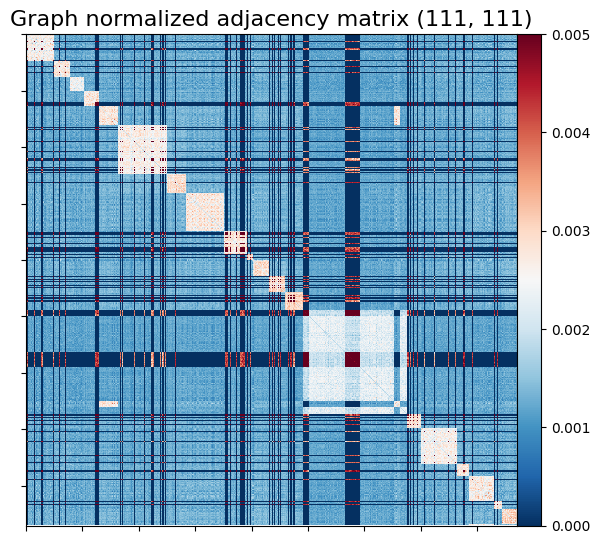

In [ ]:
# % sanity check on graph adjacency matrix
model = GCN(inp.shape[1], adj, hdim=64)
plotting.plot_matrix(
    model.adj.detach().cpu().numpy(),
    figure=(6, 6),
    vmax=0.005,
    vmin=0,
    title=f"Graph normalized adjacency matrix {mat.shape}"
)
del model

In [ ]:
training_data = {
    INPUTS: inp,
    LABELS: lab
}
metric_dict = {}
for model_name in ["Dense", "GCN"]:
    if model_name == "GCN":
        model = GCN(inp.shape[1], adj, hdim=64)
    else:
        model = DenseNN(inp.shape[1], hdim=64)
    model.to(device)

    model, metrics = training_loop(model, training_data, device, n_epochs=1000)
    metric_dict[model_name] = metrics

dict_keys(['training_losses', 'training_accuracies'])
dict_keys(['training_losses', 'training_accuracies'])


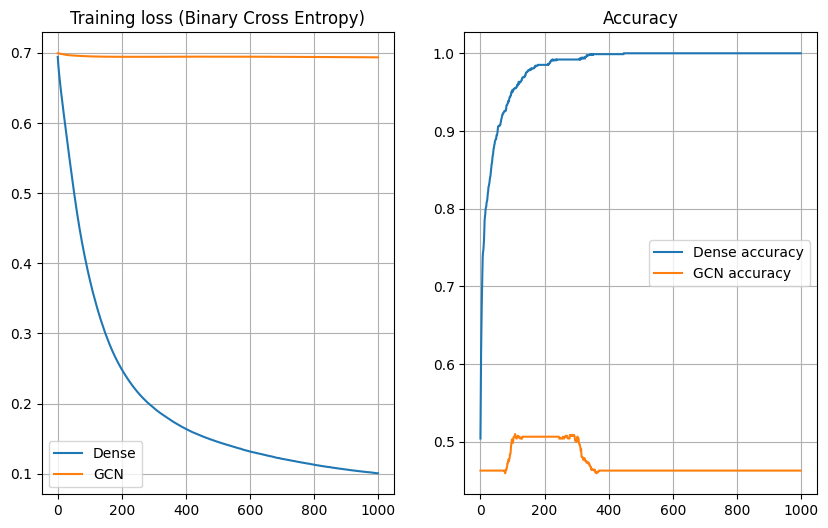

In [ ]:
def plot_metrics(metric_dict: dict):
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    for model_name, metric in metric_dict.items():
        print(metric.keys())
        axs[0].plot(metric["training_losses"], label=model_name)
        axs[1].plot(metric["training_accuracies"], label=f"{model_name} accuracy")
    for ax in axs:
        ax.legend()
        ax.grid()
    axs[0].set_title("Training loss (Binary Cross Entropy)")
    axs[1].set_title("Accuracy")

    plt.show()


plot_metrics(metric_dict)